In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# train model

In [ ]:
import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# 이미지 전처리 클래스
class ImagePreprocessor:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # 모델 입력 크기에 맞게 조정
            transforms.ToTensor(),  # 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
        ])

    def preprocess(self, image):
        return self.transform(image)

# ResNet 모델 훈련 클래스
class ResNetModelTrainer:
    def __init__(self):
        self.model = self.prepare_resnet_model()

    def prepare_resnet_model(self):
        resnet_model = models.resnet50(weights='DEFAULT')
        num_ftrs = resnet_model.fc.in_features
        num_output_values = 1
        resnet_model.fc = nn.Linear(num_ftrs, num_output_values)
        return resnet_model

    def train_and_evaluate(self, train_loader, val_loader):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        early_stopping = EarlyStopping(patience=4, min_delta=0.001)

        num_epochs = 50
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0

            for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            epoch_loss = running_loss / len(train_loader)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')

            val_loss = self.validate(val_loader, criterion)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')
            early_stopping(val_loss)

            if early_stopping.early_stop:
                print("Early stopping")
                break

        # 모델 저장
        torch.save(self.model.state_dict(), '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/resnet50_model_moisture_l.pth')

    def validate(self, val_loader, criterion):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = self.model(images)
                loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float
                val_loss += loss.item()
        return val_loss / len(val_loader)

# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# 데이터셋 클래스
class SkinDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')  # 이미지를 RGB 모드로 열기
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float)  # Convert label to float tensor

# 메인 처리 클래스
class MainProcessor:
    def __init__(self, image_folder, csv_path):
        self.image_folder = image_folder
        self.csv_path = csv_path
        self.preprocessor = ImagePreprocessor()
        self.trainer = ResNetModelTrainer()

    def extract_patches_and_labels(self):
        df = pd.read_csv(self.csv_path)
        image_files = []
        labels = []

        for image_file in os.listdir(self.image_folder):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(self.image_folder, image_file)
                image_id = image_file.split('_')[0]
                label_data = df[df['ID'] == int(image_id)]['moisture_l'].values
                if len(label_data) > 0:
                    label = label_data[0]
                    image_files.append(image_path)
                    labels.append(label)

        return image_files, labels

    def process_and_train(self):
        image_files, labels = self.extract_patches_and_labels()

        X_train, X_val, y_train, y_val = train_test_split(image_files, labels, test_size=0.2, random_state=42)

        train_dataset = SkinDataset(image_files=X_train, labels=y_train, transform=self.preprocessor.preprocess)
        val_dataset = SkinDataset(image_files=X_val, labels=y_val, transform=self.preprocessor.preprocess)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

        self.trainer.train_and_evaluate(train_loader, val_loader)


if __name__ == "__main__":
    train_image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_l_images_train'
    csv_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/train_val_dataset.csv'

    processor = MainProcessor(train_image_folder, csv_path)
    processor.process_and_train()



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 62.2MB/s]
                                                           

Epoch [1/50], Train Loss: 0.0459


Epoch [1/50], Validation Loss: 0.0451


Epoch [2/50], Train Loss: 0.0170


Epoch [2/50], Validation Loss: 0.0167


Epoch [3/50], Train Loss: 0.0095


Epoch [3/50], Validation Loss: 0.0183


Epoch [4/50], Train Loss: 0.0093


Epoch [4/50], Validation Loss: 0.0193


Epoch [5/50], Train Loss: 0.0107


Epoch [5/50], Validation Loss: 0.0194


Epoch [6/50], Train Loss: 0.0058


Epoch [6/50], Validation Loss: 0.0154


Epoch [7/50], Train Loss: 0.0040


Epoch [7/50], Validation Loss: 0.0140


Epoch [8/50], Train Loss: 0.0041


Epoch [8/50], Validation Loss: 0.0161


Epoch [9/50], Train Loss: 0.0059


Epoch [9/50], Validation Loss: 0.0195


Epoch [10/50], Train Loss: 0.0040


Epoch [10/50], Validation Loss: 0.0159


Epoch [11/50], Train Loss: 0.0027


Epoch [11/50], Validation Loss: 0.0157
Early stopping


# TEST1

# TEST2

In [ ]:
import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import matplotlib.pyplot as plt

# 데이터셋 클래스
class SkinDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')  # 이미지를 RGB 모드로 열기
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor([label], dtype=torch.float32)  # 2D 텐서로 변환

# ResNet 모델 평가 클래스
class ResNetModelEvaluator:
    def __init__(self, model_path):
        self.model = self.prepare_resnet_model()
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()

    def prepare_resnet_model(self):
        resnet_model = models.resnet50(weights='DEFAULT')
        num_ftrs = resnet_model.fc.in_features
        num_output_values = 1
        resnet_model.fc = nn.Linear(num_ftrs, num_output_values)
        return resnet_model

    def predict(self, test_loader):
        predictions = []
        actuals = []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = self.model(images)
                predictions.extend(outputs.view(-1).cpu().numpy())
                actuals.extend(labels.view(-1).cpu().numpy())
        return actuals, predictions

# 테스트 및 예측 저장 클래스
class MainProcessor:
    def __init__(self, test_image_folder, csv_path, model_path):
        self.test_image_folder = test_image_folder
        self.csv_path = csv_path
        self.model_path = model_path
        self.preprocessor = ImagePreprocessor()
        self.evaluator = ResNetModelEvaluator(model_path)

    def extract_data(self):
        df = pd.read_csv(self.csv_path)
        image_files = []
        labels = []

        for image_file in os.listdir(self.test_image_folder):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(self.test_image_folder, image_file)
                image_id = image_file.split('_')[0]
                label_data = df[df['ID'] == int(image_id)]['moisture_l'].values
                if len(label_data) > 0:
                    label = label_data[0]
                    image_files.append(image_path)
                    labels.append(label)

        return image_files, labels

    def process_and_predict(self):
        image_files, labels = self.extract_data()

        dataset = SkinDataset(image_files=image_files, labels=labels, transform=self.preprocessor.preprocess)
        data_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

        actuals, predictions = self.evaluator.predict(data_loader)

        return actuals, predictions

if __name__ == "__main__":
    test_image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_l_images_val'
    csv_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/train_val_dataset.csv'
    model_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/resnet50_model_moisture_l.pth'

    processor = MainProcessor(test_image_folder, csv_path, model_path)
    actuals, predictions = processor.process_and_predict()

    # 예측값과 실제값을 CSV로 저장
    results_df = pd.DataFrame({'Actual': actuals, 'Predicted': predictions})
    results_df.to_csv('/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/resnet50_model_moisture_l.csv', index=False)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


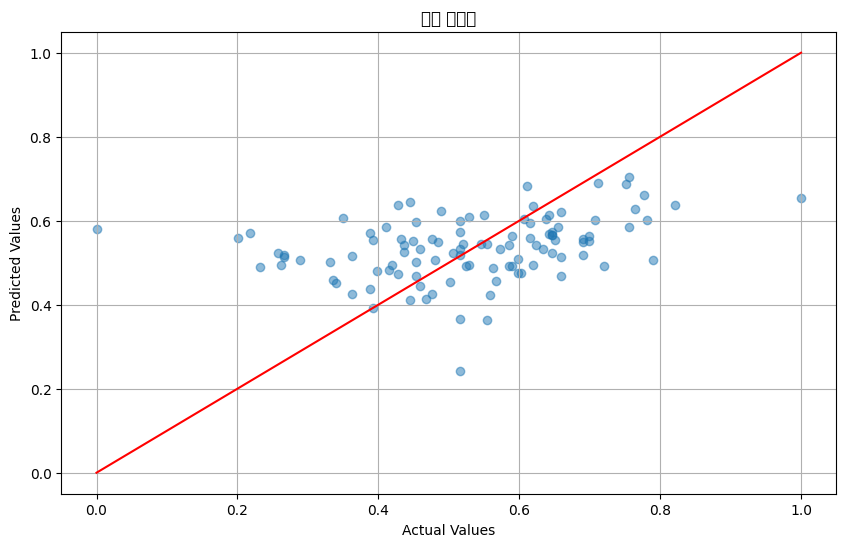

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 예측 결과 CSV 파일 읽기
results_df = pd.read_csv('/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/resnet50_model_moisture_l.csv')

# 실제값과 예측값 추출
actuals = results_df['Actual']
predictions = results_df['Predicted']

# 산점도 시각화
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red')  # y=x 선
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('비교 시각화')
plt.grid(True)
plt.show()

# 특징 추출기 사용

In [ ]:
import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# 이미지 전처리 클래스
class ImagePreprocessor:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # 모델 입력 크기에 맞게 조정
            transforms.ToTensor(),  # 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
        ])

    def preprocess(self, image):
        return self.transform(image)

# ResNet 모델 훈련 클래스
class ResNetModelTrainer:
    def __init__(self):
        self.model = self.prepare_resnet_model()

    def prepare_resnet_model(self):
        resnet_model = models.resnet50(pretrained=True)  # 사전 훈련된 모델 불러오기
        num_ftrs = resnet_model.fc.in_features
        num_output_values = 1
        resnet_model.fc = nn.Linear(num_ftrs, num_output_values)  # 마지막 레이어를 조정
        return resnet_model

    def train_and_evaluate(self, train_loader, val_loader):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        early_stopping = EarlyStopping(patience=4, min_delta=0.001)

        num_epochs = 50
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0

            for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            epoch_loss = running_loss / len(train_loader)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')

            val_loss = self.validate(val_loader, criterion)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')
            early_stopping(val_loss)

            if early_stopping.early_stop:
                print("Early stopping")
                break

        # 모델 저장
        torch.save(self.model.state_dict(), '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/resnet50_model_moisture_l.pth')

    def validate(self, val_loader, criterion):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = self.model(images)
                loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float
                val_loss += loss.item()
        return val_loss / len(val_loader)

# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# 데이터셋 클래스
class SkinDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')  # 이미지를 RGB 모드로 열기
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float)  # Convert label to float tensor

# 메인 처리 클래스
class MainProcessor:
    def __init__(self, image_folder, csv_path):
        self.image_folder = image_folder
        self.csv_path = csv_path
        self.preprocessor = ImagePreprocessor()
        self.trainer = ResNetModelTrainer()

    def extract_patches_and_labels(self):
        df = pd.read_csv(self.csv_path)
        image_files = []
        labels = []

        for image_file in os.listdir(self.image_folder):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(self.image_folder, image_file)
                image_id = image_file.split('_')[0]
                label_data = df[df['ID'] == int(image_id)]['moisture_l'].values
                if len(label_data) > 0:
                    label = label_data[0]
                    image_files.append(image_path)
                    labels.append(label)

        return image_files, labels

    def process_and_train(self):
        image_files, labels = self.extract_patches_and_labels()

        X_train, X_val, y_train, y_val = train_test_split(image_files, labels, test_size=0.2, random_state=42)

        train_dataset = SkinDataset(image_files=X_train, labels=y_train, transform=self.preprocessor.preprocess)
        val_dataset = SkinDataset(image_files=X_val, labels=y_val, transform=self.preprocessor.preprocess)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

        self.trainer.train_and_evaluate(train_loader, val_loader)


if __name__ == "__main__":
    train_image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_l_images_train'
    csv_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/train_val_dataset.csv'

    processor = MainProcessor(train_image_folder, csv_path)
    processor.process_and_train()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]
                                                           

Epoch [1/50], Train Loss: 0.3480


Epoch [1/50], Validation Loss: 1.8911


Epoch [2/50], Train Loss: 0.0277


Epoch [2/50], Validation Loss: 0.0164


Epoch [3/50], Train Loss: 0.0187


Epoch [3/50], Validation Loss: 0.0155


Epoch [4/50], Train Loss: 0.0173


Epoch [4/50], Validation Loss: 0.0159


Epoch [5/50], Train Loss: 0.0163


Epoch [5/50], Validation Loss: 0.0146


Epoch [6/50], Train Loss: 0.0174


Epoch [6/50], Validation Loss: 0.0151


Epoch [7/50], Train Loss: 0.0183


Epoch [7/50], Validation Loss: 0.0192


Epoch [8/50], Train Loss: 0.0188


Epoch [8/50], Validation Loss: 0.0293


Epoch [9/50], Train Loss: 0.0216


Epoch [9/50], Validation Loss: 0.0150
Early stopping


In [ ]:
import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import matplotlib.pyplot as plt

# 데이터셋 클래스
class SkinDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')  # 이미지를 RGB 모드로 열기
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor([label], dtype=torch.float32)  # 2D 텐서로 변환

# ResNet 모델 평가 클래스
class ResNetModelEvaluator:
    def __init__(self, model_path):
        self.model = self.prepare_resnet_model()
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()

    def prepare_resnet_model(self):
        resnet_model = models.resnet50(weights='DEFAULT')
        num_ftrs = resnet_model.fc.in_features
        num_output_values = 1
        resnet_model.fc = nn.Linear(num_ftrs, num_output_values)
        return resnet_model

    def predict(self, test_loader):
        predictions = []
        actuals = []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = self.model(images)
                predictions.extend(outputs.view(-1).cpu().numpy())
                actuals.extend(labels.view(-1).cpu().numpy())
        return actuals, predictions

# 테스트 및 예측 저장 클래스
class MainProcessor:
    def __init__(self, test_image_folder, csv_path, model_path):
        self.test_image_folder = test_image_folder
        self.csv_path = csv_path
        self.model_path = model_path
        self.preprocessor = ImagePreprocessor()
        self.evaluator = ResNetModelEvaluator(model_path)

    def extract_data(self):
        df = pd.read_csv(self.csv_path)
        image_files = []
        labels = []

        for image_file in os.listdir(self.test_image_folder):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(self.test_image_folder, image_file)
                image_id = image_file.split('_')[0]
                label_data = df[df['ID'] == int(image_id)]['moisture_l'].values
                if len(label_data) > 0:
                    label = label_data[0]
                    image_files.append(image_path)
                    labels.append(label)

        return image_files, labels

    def process_and_predict(self):
        image_files, labels = self.extract_data()

        dataset = SkinDataset(image_files=image_files, labels=labels, transform=self.preprocessor.preprocess)
        data_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

        actuals, predictions = self.evaluator.predict(data_loader)

        return actuals, predictions

if __name__ == "__main__":
    test_image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_l_images_val'
    csv_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/train_val_dataset.csv'
    model_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/resnet50_model_moisture_l.pth'

    processor = MainProcessor(test_image_folder, csv_path, model_path)
    actuals, predictions = processor.process_and_predict()

    # 예측값과 실제값을 CSV로 저장
    results_df = pd.DataFrame({'Actual': actuals, 'Predicted': predictions})
    results_df.to_csv('/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/resnet50_model_moisture_l.csv', index=False)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


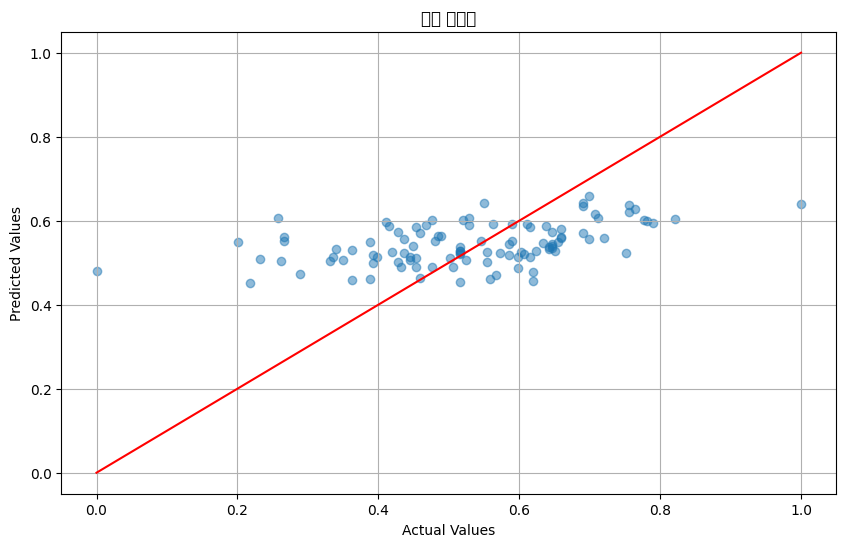

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 예측 결과 CSV 파일 읽기
results_df = pd.read_csv('/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/resnet50_model_moisture_l.csv')

# 실제값과 예측값 추출
actuals = results_df['Actual']
predictions = results_df['Predicted']

# 산점도 시각화
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red')  # y=x 선
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('비교 시각화')
plt.grid(True)
plt.show()

# 데이터 증강

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
                                                           

Epoch [1/50], Train Loss: 0.3898


Epoch [1/50], Validation Loss: 23.3912


Epoch [2/50], Train Loss: 0.0235


Epoch [2/50], Validation Loss: 0.0209


Epoch [3/50], Train Loss: 0.0218


Epoch [3/50], Validation Loss: 0.0148


Epoch [4/50], Train Loss: 0.0205


Epoch [4/50], Validation Loss: 0.0352


Epoch [5/50], Train Loss: 0.0266


Epoch [5/50], Validation Loss: 0.0157


Epoch [6/50], Train Loss: 0.0206


Epoch [6/50], Validation Loss: 0.0156


Epoch [7/50], Train Loss: 0.0205


Epoch [7/50], Validation Loss: 0.0175
Early stopping


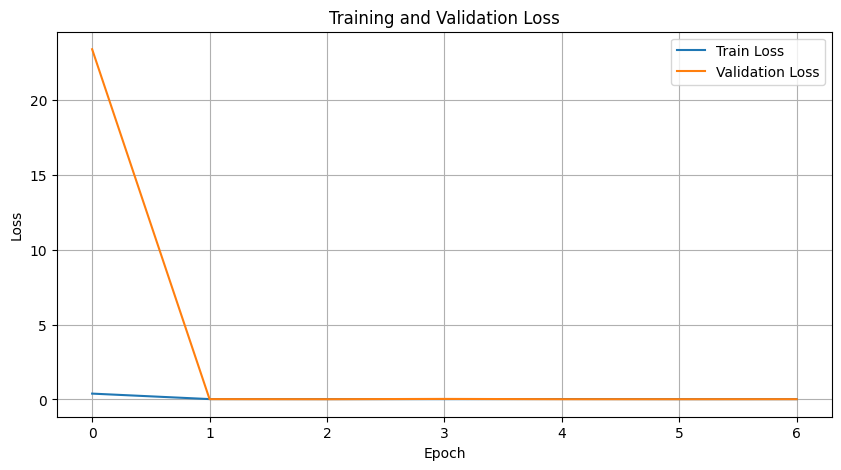

In [ ]:
import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# 이미지 전처리 클래스
class ImagePreprocessor:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # 모델 입력 크기에 맞게 조정
            transforms.RandomHorizontalFlip(),  # 데이터 증강
            transforms.RandomVerticalFlip(),  # 데이터 증강
            transforms.RandomRotation(30),  # 데이터 증강
            transforms.ToTensor(),  # 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
        ])

    def preprocess(self, image):
        return self.transform(image)

# ResNet 모델 훈련 클래스
class ResNetModelTrainer:
    def __init__(self):
        self.model = self.prepare_resnet_model()
        self.train_losses = []
        self.val_losses = []

    def prepare_resnet_model(self):
        resnet_model = models.resnet50(pretrained=True)  # 사전 훈련된 모델 불러오기
        num_ftrs = resnet_model.fc.in_features
        num_output_values = 1
        resnet_model.fc = nn.Linear(num_ftrs, num_output_values)  # 마지막 레이어를 조정
        return resnet_model

    def train_and_evaluate(self, train_loader, val_loader):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        early_stopping = EarlyStopping(patience=4, min_delta=0.001)

        num_epochs = 50
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0

            for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            epoch_loss = running_loss / len(train_loader)
            self.train_losses.append(epoch_loss)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')

            val_loss = self.validate(val_loader, criterion)
            self.val_losses.append(val_loss)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')
            early_stopping(val_loss)

            if early_stopping.early_stop:
                print("Early stopping")
                break

        # 모델 저장
        torch.save(self.model.state_dict(), '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/resnet50_model_moisture_l_v3.pth')

        # 손실 곡선 시각화
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.train_losses)), self.train_losses, label='Train Loss')
        plt.plot(range(len(self.val_losses)), self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def validate(self, val_loader, criterion):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = self.model(images)
                loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float
                val_loss += loss.item()
        return val_loss / len(val_loader)

# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# 데이터셋 클래스
class SkinDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')  # 이미지를 RGB 모드로 열기
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float)  # Convert label to float tensor

# 메인 처리 클래스
class MainProcessor:
    def __init__(self, image_folder, csv_path):
        self.image_folder = image_folder
        self.csv_path = csv_path
        self.preprocessor = ImagePreprocessor()
        self.trainer = ResNetModelTrainer()

    def extract_patches_and_labels(self):
        df = pd.read_csv(self.csv_path)
        image_files = []
        labels = []

        for image_file in os.listdir(self.image_folder):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(self.image_folder, image_file)
                image_id = image_file.split('_')[0]
                label_data = df[df['ID'] == int(image_id)]['moisture_l'].values
                if len(label_data) > 0:
                    label = label_data[0]
                    image_files.append(image_path)
                    labels.append(label)

        return image_files, labels

    def process_and_train(self):
        image_files, labels = self.extract_patches_and_labels()

        X_train, X_val, y_train, y_val = train_test_split(image_files, labels, test_size=0.2, random_state=42)

        train_dataset = SkinDataset(image_files=X_train, labels=y_train, transform=self.preprocessor.preprocess)
        val_dataset = SkinDataset(image_files=X_val, labels=y_val, transform=self.preprocessor.preprocess)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

        self.trainer.train_and_evaluate(train_loader, val_loader)

if __name__ == "__main__":
    train_image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_l_images_train'
    csv_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/train_val_dataset.csv'

    processor = MainProcessor(train_image_folder, csv_path)
    processor.process_and_train()


In [ ]:

import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import matplotlib.pyplot as plt

# 데이터셋 클래스
class SkinDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')  # 이미지를 RGB 모드로 열기
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor([label], dtype=torch.float32)  # 2D 텐서로 변환

# ResNet 모델 평가 클래스
class ResNetModelEvaluator:
    def __init__(self, model_path):
        self.model = self.prepare_resnet_model()
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()

    def prepare_resnet_model(self):
        resnet_model = models.resnet50(weights='DEFAULT')
        num_ftrs = resnet_model.fc.in_features
        num_output_values = 1
        resnet_model.fc = nn.Linear(num_ftrs, num_output_values)
        return resnet_model

    def predict(self, test_loader):
        predictions = []
        actuals = []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = self.model(images)
                predictions.extend(outputs.view(-1).cpu().numpy())
                actuals.extend(labels.view(-1).cpu().numpy())
        return actuals, predictions

# 테스트 및 예측 저장 클래스
class MainProcessor:
    def __init__(self, test_image_folder, csv_path, model_path):
        self.test_image_folder = test_image_folder
        self.csv_path = csv_path
        self.model_path = model_path
        self.preprocessor = ImagePreprocessor()
        self.evaluator = ResNetModelEvaluator(model_path)

    def extract_data(self):
        df = pd.read_csv(self.csv_path)
        image_files = []
        labels = []

        for image_file in os.listdir(self.test_image_folder):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(self.test_image_folder, image_file)
                image_id = image_file.split('_')[0]
                label_data = df[df['ID'] == int(image_id)]['moisture_l'].values
                if len(label_data) > 0:
                    label = label_data[0]
                    image_files.append(image_path)
                    labels.append(label)

        return image_files, labels

    def process_and_predict(self):
        image_files, labels = self.extract_data()

        dataset = SkinDataset(image_files=image_files, labels=labels, transform=self.preprocessor.preprocess)
        data_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

        actuals, predictions = self.evaluator.predict(data_loader)

        return actuals, predictions

if __name__ == "__main__":
    test_image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_l_images_val'
    csv_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/train_val_dataset.csv'
    model_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/resnet50_model_moisture_l_v3.pth'

    processor = MainProcessor(test_image_folder, csv_path, model_path)
    actuals, predictions = processor.process_and_predict()

    # 예측값과 실제값을 CSV로 저장
    results_df = pd.DataFrame({'Actual': actuals, 'Predicted': predictions})
    results_df.to_csv('/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/resnet50_model_moisture_l_v3.csv', index=False)


Mean Squared Error: 0.0235


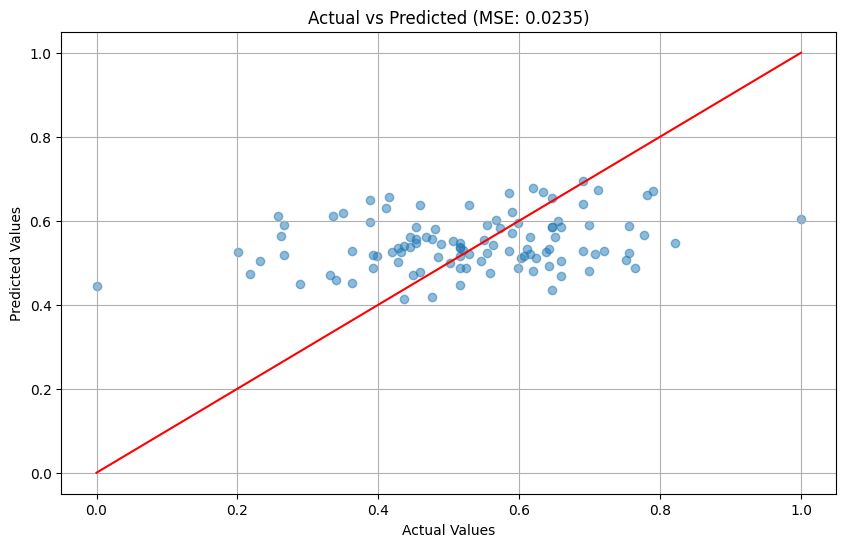

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# 예측 결과 CSV 파일 읽기
results_df = pd.read_csv('/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/resnet50_model_moisture_l_v3.csv')

# 실제값과 예측값 추출
actuals = results_df['Actual']
predictions = results_df['Predicted']

# MSE 계산
mse = mean_squared_error(actuals, predictions)
print(f'Mean Squared Error: {mse:.4f}')

# 산점도 시각화
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red')  # y=x 선
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted (MSE: {mse:.4f})')  # MSE를 제목에 추가
plt.grid(True)
plt.show()

# measurement_data

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
                                                           

Epoch [1/50], Train Loss: 2308.7489


Epoch [1/50], Validation Loss: 675.4762


Epoch [2/50], Train Loss: 381.5109


Epoch [2/50], Validation Loss: 134.8202


Epoch [3/50], Train Loss: 105.0974


Epoch [3/50], Validation Loss: 146.9987


Epoch [4/50], Train Loss: 116.9051


Epoch [4/50], Validation Loss: 150.5089


Epoch [5/50], Train Loss: 105.0882


Epoch [5/50], Validation Loss: 99.0660


Epoch [6/50], Train Loss: 104.0304


Epoch [6/50], Validation Loss: 96.0911


Epoch [7/50], Train Loss: 100.3928


Epoch [7/50], Validation Loss: 108.3365


Epoch [8/50], Train Loss: 101.8088


Epoch [8/50], Validation Loss: 85.7961


Epoch [9/50], Train Loss: 107.9011


Epoch [9/50], Validation Loss: 92.7057


Epoch [10/50], Train Loss: 100.3865


Epoch [10/50], Validation Loss: 126.5758


Epoch [11/50], Train Loss: 111.8843


Epoch [11/50], Validation Loss: 97.2432


Epoch [12/50], Train Loss: 103.6635


Epoch [12/50], Validation Loss: 90.7227
Early stopping


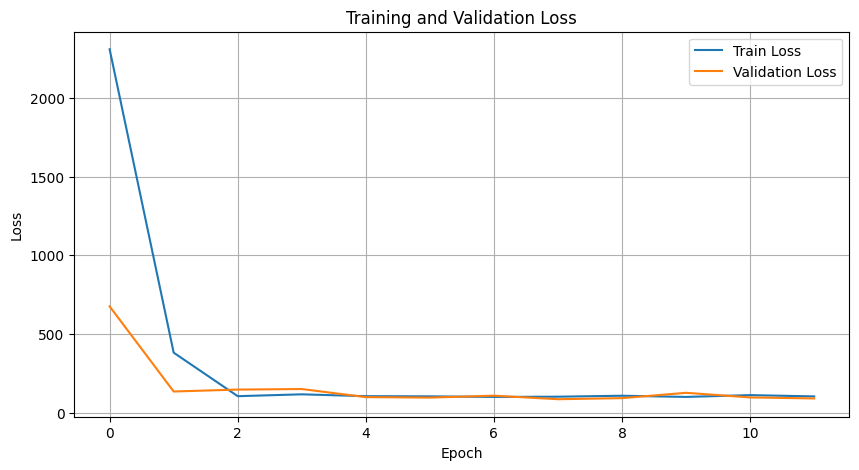

In [ ]:
import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# 이미지 전처리 클래스
class ImagePreprocessor:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # 모델 입력 크기에 맞게 조정
            transforms.RandomHorizontalFlip(),  # 데이터 증강
            transforms.RandomVerticalFlip(),  # 데이터 증강
            transforms.RandomRotation(30),  # 데이터 증강
            transforms.ToTensor(),  # 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
        ])

    def preprocess(self, image):
        return self.transform(image)

# ResNet 모델 훈련 클래스
class ResNetModelTrainer:
    def __init__(self):
        self.model = self.prepare_resnet_model()
        self.train_losses = []
        self.val_losses = []

    def prepare_resnet_model(self):
        resnet_model = models.resnet50(pretrained=True)  # 사전 훈련된 모델 불러오기
        num_ftrs = resnet_model.fc.in_features
        num_output_values = 1
        resnet_model.fc = nn.Linear(num_ftrs, num_output_values)  # 마지막 레이어를 조정
        return resnet_model

    def train_and_evaluate(self, train_loader, val_loader):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        early_stopping = EarlyStopping(patience=4, min_delta=0.001)

        num_epochs = 50
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0

            for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            epoch_loss = running_loss / len(train_loader)
            self.train_losses.append(epoch_loss)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')

            val_loss = self.validate(val_loader, criterion)
            self.val_losses.append(val_loss)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')
            early_stopping(val_loss)

            if early_stopping.early_stop:
                print("Early stopping")
                break

        # 모델 저장
        torch.save(self.model.state_dict(), '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/resnet50_model_moisture_l_v4.pth')

        # 손실 곡선 시각화
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.train_losses)), self.train_losses, label='Train Loss')
        plt.plot(range(len(self.val_losses)), self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def validate(self, val_loader, criterion):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = self.model(images)
                loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float
                val_loss += loss.item()
        return val_loss / len(val_loader)

# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# 데이터셋 클래스
class SkinDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')  # 이미지를 RGB 모드로 열기
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float)  # Convert label to float tensor

# 메인 처리 클래스
class MainProcessor:
    def __init__(self, image_folder, csv_path):
        self.image_folder = image_folder
        self.csv_path = csv_path
        self.preprocessor = ImagePreprocessor()
        self.trainer = ResNetModelTrainer()

    def extract_patches_and_labels(self):
        df = pd.read_csv(self.csv_path)
        image_files = []
        labels = []

        for image_file in os.listdir(self.image_folder):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(self.image_folder, image_file)
                image_id = image_file.split('_')[0]
                label_data = df[df['ID'] == int(image_id)]['수분_왼쪽볼'].values
                if len(label_data) > 0:
                    label = label_data[0]
                    image_files.append(image_path)
                    labels.append(label)

        return image_files, labels

    def process_and_train(self):
        image_files, labels = self.extract_patches_and_labels()

        X_train, X_val, y_train, y_val = train_test_split(image_files, labels, test_size=0.2, random_state=42)

        train_dataset = SkinDataset(image_files=X_train, labels=y_train, transform=self.preprocessor.preprocess)
        val_dataset = SkinDataset(image_files=X_val, labels=y_val, transform=self.preprocessor.preprocess)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

        self.trainer.train_and_evaluate(train_loader, val_loader)

if __name__ == "__main__":
    train_image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_l_images_train'
    csv_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/measurement_data.csv'

    processor = MainProcessor(train_image_folder, csv_path)
    processor.process_and_train()


In [ ]:

import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import matplotlib.pyplot as plt

# 데이터셋 클래스
class SkinDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')  # 이미지를 RGB 모드로 열기
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor([label], dtype=torch.float32)  # 2D 텐서로 변환

# ResNet 모델 평가 클래스
class ResNetModelEvaluator:
    def __init__(self, model_path):
        self.model = self.prepare_resnet_model()
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()

    def prepare_resnet_model(self):
        resnet_model = models.resnet50(weights='DEFAULT')
        num_ftrs = resnet_model.fc.in_features
        num_output_values = 1
        resnet_model.fc = nn.Linear(num_ftrs, num_output_values)
        return resnet_model

    def predict(self, test_loader):
        predictions = []
        actuals = []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = self.model(images)
                predictions.extend(outputs.view(-1).cpu().numpy())
                actuals.extend(labels.view(-1).cpu().numpy())
        return actuals, predictions

# 테스트 및 예측 저장 클래스
class MainProcessor:
    def __init__(self, test_image_folder, csv_path, model_path):
        self.test_image_folder = test_image_folder
        self.csv_path = csv_path
        self.model_path = model_path
        self.preprocessor = ImagePreprocessor()
        self.evaluator = ResNetModelEvaluator(model_path)

    def extract_data(self):
        df = pd.read_csv(self.csv_path)
        image_files = []
        labels = []

        for image_file in os.listdir(self.test_image_folder):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(self.test_image_folder, image_file)
                image_id = image_file.split('_')[0]
                label_data = df[df['ID'] == int(image_id)]['수분_왼쪽볼'].values
                if len(label_data) > 0:
                    label = label_data[0]
                    image_files.append(image_path)
                    labels.append(label)

        return image_files, labels

    def process_and_predict(self):
        image_files, labels = self.extract_data()

        dataset = SkinDataset(image_files=image_files, labels=labels, transform=self.preprocessor.preprocess)
        data_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

        actuals, predictions = self.evaluator.predict(data_loader)

        return actuals, predictions

if __name__ == "__main__":
    test_image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_l_images_val'
    csv_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/measurement_data.csv'
    model_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/resnet50_model_moisture_l_v4.pth'

    processor = MainProcessor(test_image_folder, csv_path, model_path)
    actuals, predictions = processor.process_and_predict()

    # 예측값과 실제값을 CSV로 저장
    results_df = pd.DataFrame({'Actual': actuals, 'Predicted': predictions})
    results_df.to_csv('/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/resnet50_model_moisture_l_v4.csv', index=False)

Mean Squared Error: 130.9660


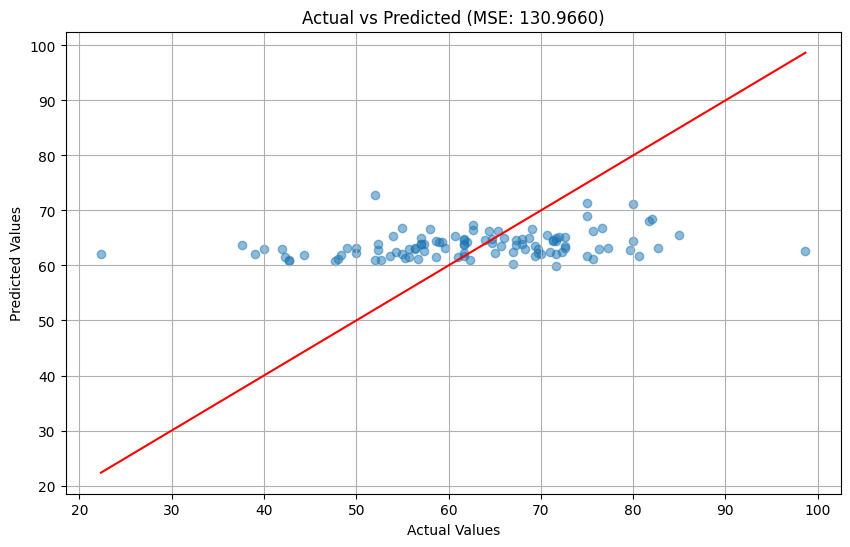

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# 예측 결과 CSV 파일 읽기
results_df = pd.read_csv('/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/resnet50_model_moisture_l_v4.csv')

# 실제값과 예측값 추출
actuals = results_df['Actual']
predictions = results_df['Predicted']

# MSE 계산
mse = mean_squared_error(actuals, predictions)
print(f'Mean Squared Error: {mse:.4f}')

# 산점도 시각화
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red')  # y=x 선
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted (MSE: {mse:.4f})')  # MSE를 제목에 추가
plt.grid(True)
plt.show()

# EfficientNet

In [3]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [4]:
import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# 이미지 전처리 클래스
class ImagePreprocessor:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # 모델 입력 크기에 맞게 조정
            transforms.ToTensor(),  # 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
        ])

    def preprocess(self, image):
        return self.transform(image)

# EfficientNet 모델 훈련 클래스
class EfficientNetModelTrainer:
    def __init__(self):
        self.model = self.prepare_efficientnet_model()

    def prepare_efficientnet_model(self):
        efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True)  # EfficientNet-B0 모델 불러오기
        num_ftrs = efficientnet_model.classifier.in_features
        num_output_values = 1
        efficientnet_model.classifier = nn.Linear(num_ftrs, num_output_values)  # 마지막 레이어를 조정
        return efficientnet_model

    def train_and_evaluate(self, train_loader, val_loader):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        early_stopping = EarlyStopping(patience=4, min_delta=0.001)

        num_epochs = 50
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0

            for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            epoch_loss = running_loss / len(train_loader)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')

            val_loss = self.validate(val_loader, criterion)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')
            early_stopping(val_loss)

            if early_stopping.early_stop:
                print("Early stopping")
                break

        # 모델 저장
        torch.save(self.model.state_dict(), '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/efficientnet_model_v1.pth')

    def validate(self, val_loader, criterion):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = self.model(images)
                loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float
                val_loss += loss.item()
        return val_loss / len(val_loader)

# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# 데이터셋 클래스
class SkinDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')  # 이미지를 RGB 모드로 열기
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float)  # Convert label to float tensor

# 메인 처리 클래스
class MainProcessor:
    def __init__(self, image_folder, csv_path):
        self.image_folder = image_folder
        self.csv_path = csv_path
        self.preprocessor = ImagePreprocessor()
        self.trainer = EfficientNetModelTrainer()

    def extract_patches_and_labels(self):
        df = pd.read_csv(self.csv_path)
        image_files = []
        labels = []

        for image_file in os.listdir(self.image_folder):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(self.image_folder, image_file)
                image_id = image_file.split('_')[0]
                label_data = df[df['ID'] == int(image_id)]['moisture_l'].values
                if len(label_data) > 0:
                    label = label_data[0]
                    image_files.append(image_path)
                    labels.append(label)

        return image_files, labels

    def process_and_train(self):
        image_files, labels = self.extract_patches_and_labels()

        X_train, X_val, y_train, y_val = train_test_split(image_files, labels, test_size=0.2, random_state=42)

        train_dataset = SkinDataset(image_files=X_train, labels=y_train, transform=self.preprocessor.preprocess)
        val_dataset = SkinDataset(image_files=X_val, labels=y_val, transform=self.preprocessor.preprocess)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

        self.trainer.train_and_evaluate(train_loader, val_loader)

if __name__ == "__main__":
    train_image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_l_images_train'
    csv_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/train_val_dataset.csv'

    processor = MainProcessor(train_image_folder, csv_path)
    processor.process_and_train()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch [1/50], Train Loss: 0.0909


Epoch [1/50], Validation Loss: 0.0863


Epoch [2/50], Train Loss: 0.0475


Epoch [2/50], Validation Loss: 0.0297


Epoch [3/50], Train Loss: 0.0195


Epoch [3/50], Validation Loss: 0.0178


Epoch [4/50], Train Loss: 0.0122


Epoch [4/50], Validation Loss: 0.0163


Epoch [5/50], Train Loss: 0.0105


Epoch [5/50], Validation Loss: 0.0159


Epoch [6/50], Train Loss: 0.0052


Epoch [6/50], Validation Loss: 0.0152


Epoch [7/50], Train Loss: 0.0022


Epoch [7/50], Validation Loss: 0.0145


Epoch [8/50], Train Loss: 0.0029


Epoch [8/50], Validation Loss: 0.0157


Epoch [9/50], Train Loss: 0.0051


Epoch [9/50], Validation Loss: 0.0149


Epoch [10/50], Train Loss: 0.0032


Epoch [10/50], Validation Loss: 0.0142
Early stopping


In [5]:
import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import torch.nn as nn

# 이미지 전처리 클래스
class ImagePreprocessor:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # 모델 입력 크기에 맞게 조정
            transforms.ToTensor(),  # 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
        ])

    def preprocess(self, image):
        return self.transform(image)

# 데이터셋 클래스
class SkinDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')  # 이미지를 RGB 모드로 열기
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor([label], dtype=torch.float32)  # 2D 텐서로 변환

# EfficientNet 모델 평가 클래스
class EfficientNetModelEvaluator:
    def __init__(self, model_path):
        self.model = self.prepare_efficientnet_model()
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()

    def prepare_efficientnet_model(self):
        efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True)  # EfficientNet-B0 모델 불러오기
        num_ftrs = efficientnet_model.classifier.in_features
        num_output_values = 1
        efficientnet_model.classifier = nn.Linear(num_ftrs, num_output_values)  # 마지막 레이어를 조정
        return efficientnet_model

    def predict(self, test_loader):
        predictions = []
        actuals = []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = self.model(images)
                predictions.extend(outputs.view(-1).cpu().numpy())
                actuals.extend(labels.view(-1).cpu().numpy())
        return actuals, predictions

# 테스트 및 예측 저장 클래스
class MainProcessor:
    def __init__(self, test_image_folder, csv_path, model_path):
        self.test_image_folder = test_image_folder
        self.csv_path = csv_path
        self.model_path = model_path
        self.preprocessor = ImagePreprocessor()
        self.evaluator = EfficientNetModelEvaluator(model_path)

    def extract_data(self):
        df = pd.read_csv(self.csv_path)
        image_files = []
        labels = []

        for image_file in os.listdir(self.test_image_folder):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(self.test_image_folder, image_file)
                image_id = image_file.split('_')[0]
                label_data = df[df['ID'] == int(image_id)]['moisture_l'].values
                if len(label_data) > 0:
                    label = label_data[0]
                    image_files.append(image_path)
                    labels.append(label)

        return image_files, labels

    def process_and_predict(self):
        image_files, labels = self.extract_data()

        dataset = SkinDataset(image_files=image_files, labels=labels, transform=self.preprocessor.preprocess)
        data_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

        actuals, predictions = self.evaluator.predict(data_loader)

        return actuals, predictions

if __name__ == "__main__":
    test_image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_l_images_val'
    csv_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/train_val_dataset.csv'
    model_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/efficientnet_model_v1.pth'

    processor = MainProcessor(test_image_folder, csv_path, model_path)
    actuals, predictions = processor.process_and_predict()

    # 예측값과 실제값을 CSV로 저장
    results_df = pd.DataFrame({'Actual': actuals, 'Predicted': predictions})
    results_df.to_csv('/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/efficientnet_model_moisture_l_v1.csv', index=False)


Mean Squared Error: 0.0234


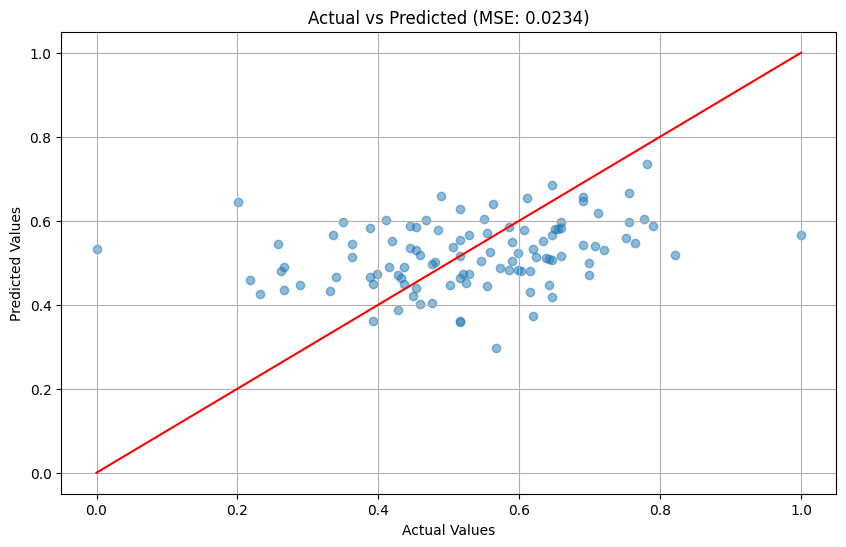

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# 예측 결과 CSV 파일 읽기
results_df = pd.read_csv('/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/efficientnet_model_moisture_l_v1.csv')

# 실제값과 예측값 추출
actuals = results_df['Actual']
predictions = results_df['Predicted']

# MSE 계산
mse = mean_squared_error(actuals, predictions)
print(f'Mean Squared Error: {mse:.4f}')

# 산점도 시각화
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red')  # y=x 선
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted (MSE: {mse:.4f})')  # MSE를 제목에 추가
plt.grid(True)
plt.show()

하이퍼파라미터 조정

In [9]:
import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# 이미지 전처리 클래스
class ImagePreprocessor:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # 모델 입력 크기에 맞게 조정
            transforms.ToTensor(),  # 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
        ])

    def preprocess(self, image):
        return self.transform(image)

# EfficientNet 모델 훈련 클래스
class EfficientNetModelTrainer:
    def __init__(self):
        self.model = self.prepare_efficientnet_model()

    def prepare_efficientnet_model(self):
        efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True)  # EfficientNet-B0 모델 불러오기
        num_ftrs = efficientnet_model.classifier.in_features
        num_output_values = 1
        efficientnet_model.classifier = nn.Linear(num_ftrs, num_output_values)  # 마지막 레이어를 조정
        return efficientnet_model

    def train_and_evaluate(self, train_loader, val_loader):
        criterion = nn.MSELoss()

        # AdamW 옵티마이저와 조정된 learning rate
        optimizer = optim.AdamW(self.model.parameters(), lr=0.0001)

        # StepLR 스케줄러로 10 에포크마다 학습률을 0.1배로 줄임
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        early_stopping = EarlyStopping(patience=4, min_delta=0.001)

        num_epochs = 50
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0

            for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            epoch_loss = running_loss / len(train_loader)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')

            val_loss = self.validate(val_loader, criterion)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')
            early_stopping(val_loss)
            scheduler.step()  # 스케줄러 스텝 업데이트

            if early_stopping.early_stop:
                print("Early stopping")
                break

        # 모델 저장
        torch.save(self.model.state_dict(), '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/efficientnet_model_v2.pth')

    def validate(self, val_loader, criterion):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = self.model(images)
                loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float
                val_loss += loss.item()
        return val_loss / len(val_loader)

# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# 데이터셋 클래스
class SkinDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')  # 이미지를 RGB 모드로 열기
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float)  # Convert label to float tensor

# 메인 처리 클래스
class MainProcessor:
    def __init__(self, image_folder, csv_path):
        self.image_folder = image_folder
        self.csv_path = csv_path
        self.preprocessor = ImagePreprocessor()
        self.trainer = EfficientNetModelTrainer()

    def extract_patches_and_labels(self):
        df = pd.read_csv(self.csv_path)
        image_files = []
        labels = []

        for image_file in os.listdir(self.image_folder):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(self.image_folder, image_file)
                image_id = image_file.split('_')[0]
                label_data = df[df['ID'] == int(image_id)]['moisture_l'].values
                if len(label_data) > 0:
                    label = label_data[0]
                    image_files.append(image_path)
                    labels.append(label)

        return image_files, labels

    def process_and_train(self):
        image_files, labels = self.extract_patches_and_labels()

        X_train, X_val, y_train, y_val = train_test_split(image_files, labels, test_size=0.2, random_state=42)

        train_dataset = SkinDataset(image_files=X_train, labels=y_train, transform=self.preprocessor.preprocess)
        val_dataset = SkinDataset(image_files=X_val, labels=y_val, transform=self.preprocessor.preprocess)

        # Batch size를 64로 조정
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

        self.trainer.train_and_evaluate(train_loader, val_loader)

if __name__ == "__main__":
    train_image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_l_images_train'
    csv_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/train_val_dataset.csv'

    processor = MainProcessor(train_image_folder, csv_path)
    processor.process_and_train()


Epoch [1/50], Train Loss: 0.1527


Epoch [1/50], Validation Loss: 0.1177


Epoch [2/50], Train Loss: 0.0300


Epoch [2/50], Validation Loss: 0.0445


Epoch [3/50], Train Loss: 0.0151


Epoch [3/50], Validation Loss: 0.0357


Epoch [4/50], Train Loss: 0.0103


Epoch [4/50], Validation Loss: 0.0323


Epoch [5/50], Train Loss: 0.0078


Epoch [5/50], Validation Loss: 0.0301


Epoch [6/50], Train Loss: 0.0064


Epoch [6/50], Validation Loss: 0.0291


Epoch [7/50], Train Loss: 0.0055


Epoch [7/50], Validation Loss: 0.0286


Epoch [8/50], Train Loss: 0.0053


Epoch [8/50], Validation Loss: 0.0288


Epoch [9/50], Train Loss: 0.0041


Epoch [9/50], Validation Loss: 0.0297


Epoch [10/50], Train Loss: 0.0046


Epoch [10/50], Validation Loss: 0.0284


Epoch [11/50], Train Loss: 0.0037


Epoch [11/50], Validation Loss: 0.0285
Early stopping


In [15]:
import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import torch.nn as nn

# 이미지 전처리 클래스
class ImagePreprocessor:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # 모델 입력 크기에 맞게 조정
            transforms.ToTensor(),  # 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
        ])

    def preprocess(self, image):
        return self.transform(image)

# 데이터셋 클래스
class SkinDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')  # 이미지를 RGB 모드로 열기
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor([label], dtype=torch.float32)  # 2D 텐서로 변환

# EfficientNet 모델 평가 클래스
class EfficientNetModelEvaluator:
    def __init__(self, model_path):
        self.model = self.prepare_efficientnet_model()
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()

    def prepare_efficientnet_model(self):
        efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True)  # EfficientNet-B0 모델 불러오기
        num_ftrs = efficientnet_model.classifier.in_features
        num_output_values = 1
        efficientnet_model.classifier = nn.Linear(num_ftrs, num_output_values)  # 마지막 레이어를 조정
        return efficientnet_model

    def predict(self, test_loader):
        predictions = []
        actuals = []
        self.model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = self.model(images)
                predictions.extend(outputs.view(-1).cpu().numpy())
                actuals.extend(labels.view(-1).cpu().numpy())
        return actuals, predictions

# 테스트 및 예측 저장 클래스
class MainProcessor:
    def __init__(self, test_image_folder, csv_path, model_path):
        self.test_image_folder = test_image_folder
        self.csv_path = csv_path
        self.model_path = model_path
        self.preprocessor = ImagePreprocessor()
        self.evaluator = EfficientNetModelEvaluator(model_path)

    def extract_data(self):
        df = pd.read_csv(self.csv_path)
        image_files = []
        labels = []

        for image_file in os.listdir(self.test_image_folder):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(self.test_image_folder, image_file)
                image_id = image_file.split('_')[0]
                label_data = df[df['ID'] == int(image_id)]['moisture_l'].values
                if len(label_data) > 0:
                    label = label_data[0]
                    image_files.append(image_path)
                    labels.append(label)

        return image_files, labels

    def process_and_predict(self):
        image_files, labels = self.extract_data()

        dataset = SkinDataset(image_files=image_files, labels=labels, transform=self.preprocessor.preprocess)
        data_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

        actuals, predictions = self.evaluator.predict(data_loader)

        return actuals, predictions

if __name__ == "__main__":
    test_image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_l_images_val'
    csv_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/train_val_dataset.csv'
    model_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/efficientnet_model_v2.pth'

    processor = MainProcessor(test_image_folder, csv_path, model_path)
    actuals, predictions = processor.process_and_predict()

    # 예측값과 실제값을 CSV로 저장
    results_df = pd.DataFrame({'Actual': actuals, 'Predicted': predictions})
    results_df.to_csv('/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/efficientnet_model_moisture_l_v2.csv', index=False)


Mean Squared Error: 0.0305


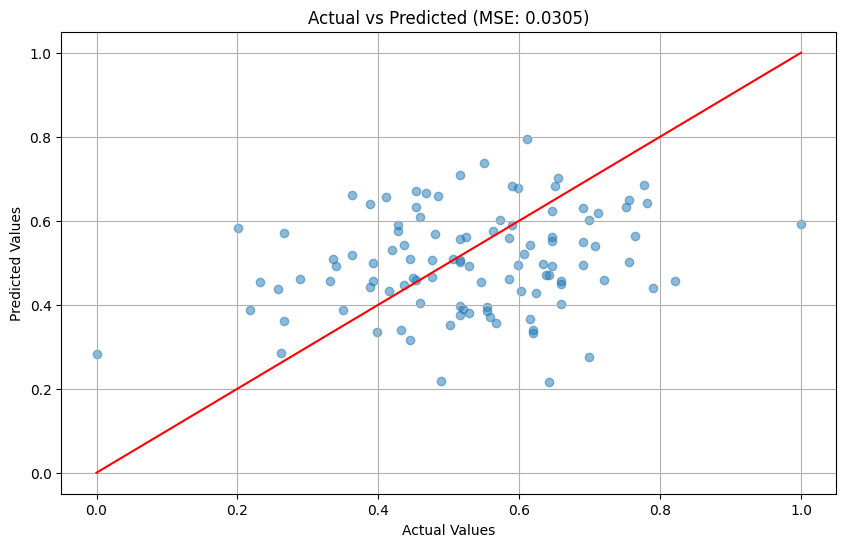

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# 예측 결과 CSV 파일 읽기
results_df = pd.read_csv('/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/efficientnet_model_moisture_l_v2.csv')

# 실제값과 예측값 추출
actuals = results_df['Actual']
predictions = results_df['Predicted']

# MSE 계산
mse = mean_squared_error(actuals, predictions)
print(f'Mean Squared Error: {mse:.4f}')

# 산점도 시각화
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red')  # y=x 선
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted (MSE: {mse:.4f})')  # MSE를 제목에 추가
plt.grid(True)
plt.show()

# VGG 모델

In [18]:
import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# 이미지 전처리 클래스
class ImagePreprocessor:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # 모델 입력 크기에 맞게 조정
            transforms.ToTensor(),  # 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
        ])

    def preprocess(self, image):
        return self.transform(image)

# VGG 모델 훈련 클래스
class VGGModelTrainer:
    def __init__(self):
        self.model = self.prepare_vgg_model()

    def prepare_vgg_model(self):
        vgg_model = models.vgg16(pretrained=True)  # VGG16 모델 불러오기
        num_ftrs = vgg_model.classifier[6].in_features
        num_output_values = 1
        vgg_model.classifier[6] = nn.Linear(num_ftrs, num_output_values)  # 마지막 레이어를 조정
        return vgg_model

    def train_and_evaluate(self, train_loader, val_loader):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        early_stopping = EarlyStopping(patience=4, min_delta=0.001)

        num_epochs = 50
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0

            for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            epoch_loss = running_loss / len(train_loader)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')

            val_loss = self.validate(val_loader, criterion)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')
            early_stopping(val_loss)

            if early_stopping.early_stop:
                print("Early stopping")
                break

        # 모델 저장
        torch.save(self.model.state_dict(), '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/vgg16_model_v1.pth')

    def validate(self, val_loader, criterion):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = self.model(images)
                loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float
                val_loss += loss.item()
        return val_loss / len(val_loader)

# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# 데이터셋 클래스
class SkinDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')  # 이미지를 RGB 모드로 열기
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float)  # Convert label to float tensor

# 메인 처리 클래스
class MainProcessor:
    def __init__(self, image_folder, csv_path):
        self.image_folder = image_folder
        self.csv_path = csv_path
        self.preprocessor = ImagePreprocessor()
        self.trainer = VGGModelTrainer()

    def extract_patches_and_labels(self):
        df = pd.read_csv(self.csv_path)
        image_files = []
        labels = []

        for image_file in os.listdir(self.image_folder):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(self.image_folder, image_file)
                image_id = image_file.split('_')[0]
                label_data = df[df['ID'] == int(image_id)]['moisture_l'].values
                if len(label_data) > 0:
                    label = label_data[0]
                    image_files.append(image_path)
                    labels.append(label)

        return image_files, labels

    def process_and_train(self):
        image_files, labels = self.extract_patches_and_labels()

        X_train, X_val, y_train, y_val = train_test_split(image_files, labels, test_size=0.2, random_state=42)

        train_dataset = SkinDataset(image_files=X_train, labels=y_train, transform=self.preprocessor.preprocess)
        val_dataset = SkinDataset(image_files=X_val, labels=y_val, transform=self.preprocessor.preprocess)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

        self.trainer.train_and_evaluate(train_loader, val_loader)

if __name__ == "__main__":
    train_image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_l_images_train'
    csv_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/train_val_dataset.csv'

    processor = MainProcessor(train_image_folder, csv_path)
    processor.process_and_train()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 179MB/s]
                                                           

Epoch [1/50], Train Loss: 15.4980


Epoch [1/50], Validation Loss: 0.0890


Epoch [2/50], Train Loss: 0.0520


Epoch [2/50], Validation Loss: 0.0160


Epoch [3/50], Train Loss: 0.0270


Epoch [3/50], Validation Loss: 0.0180


Epoch [4/50], Train Loss: 0.0233


Epoch [4/50], Validation Loss: 0.0178


Epoch [5/50], Train Loss: 0.0290


Epoch [5/50], Validation Loss: 0.0158


Epoch [6/50], Train Loss: 0.0234


Epoch [6/50], Validation Loss: 0.0291
Early stopping


In [19]:
import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn

# 이미지 전처리 클래스
class ImagePreprocessor:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # 모델 입력 크기에 맞게 조정
            transforms.ToTensor(),  # 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
        ])

    def preprocess(self, image):
        return self.transform(image)

# 데이터셋 클래스
class SkinDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')  # 이미지를 RGB 모드로 열기
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor([label], dtype=torch.float32)  # 2D 텐서로 변환

# VGG 모델 평가 클래스
class VGGModelEvaluator:
    def __init__(self, model_path):
        self.model = self.prepare_vgg_model()
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()

    def prepare_vgg_model(self):
        vgg_model = models.vgg16(pretrained=True)  # VGG16 모델 불러오기
        num_ftrs = vgg_model.classifier[6].in_features
        num_output_values = 1
        vgg_model.classifier[6] = nn.Linear(num_ftrs, num_output_values)  # 마지막 레이어를 조정
        return vgg_model

    def predict(self, test_loader):
        predictions = []
        actuals = []
        self.model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = self.model(images)
                predictions.extend(outputs.view(-1).cpu().numpy())
                actuals.extend(labels.view(-1).cpu().numpy())
        return actuals, predictions

# 테스트 및 예측 저장 클래스
class MainProcessor:
    def __init__(self, test_image_folder, csv_path, model_path):
        self.test_image_folder = test_image_folder
        self.csv_path = csv_path
        self.model_path = model_path
        self.preprocessor = ImagePreprocessor()
        self.evaluator = VGGModelEvaluator(model_path)

    def extract_data(self):
        df = pd.read_csv(self.csv_path)
        image_files = []
        labels = []

        for image_file in os.listdir(self.test_image_folder):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(self.test_image_folder, image_file)
                image_id = image_file.split('_')[0]
                label_data = df[df['ID'] == int(image_id)]['moisture_l'].values
                if len(label_data) > 0:
                    label = label_data[0]
                    image_files.append(image_path)
                    labels.append(label)

        return image_files, labels

    def process_and_predict(self):
        image_files, labels = self.extract_data()

        dataset = SkinDataset(image_files=image_files, labels=labels, transform=self.preprocessor.preprocess)
        data_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

        actuals, predictions = self.evaluator.predict(data_loader)

        return actuals, predictions

if __name__ == "__main__":
    test_image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_l_images_val'
    csv_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/train_val_dataset.csv'
    model_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/vgg16_model_v1.pth'

    processor = MainProcessor(test_image_folder, csv_path, model_path)
    actuals, predictions = processor.process_and_predict()

    # 예측값과 실제값을 CSV로 저장
    results_df = pd.DataFrame({'Actual': actuals, 'Predicted': predictions})
    results_df.to_csv('/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/vgg16_model_moisture_l_v1.csv', index=False)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mean Squared Error: 0.0336


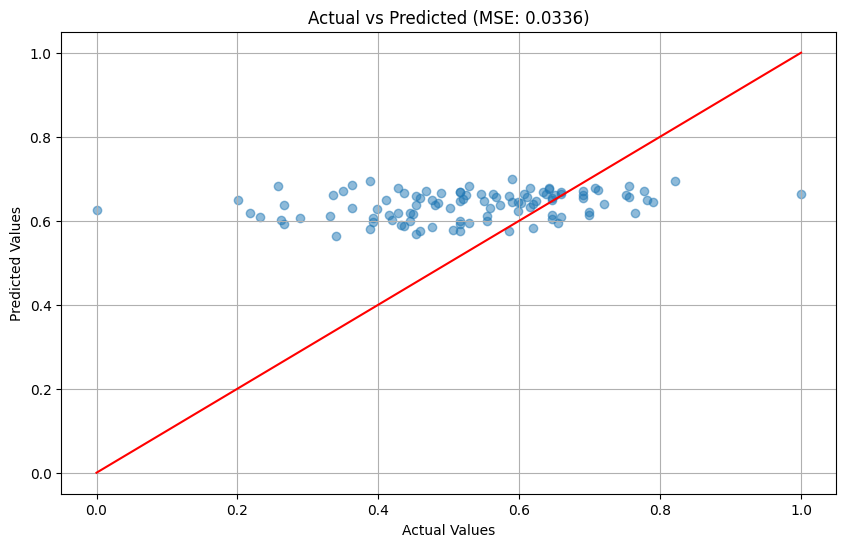

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# 예측 결과 CSV 파일 읽기
results_df = pd.read_csv('/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/vgg16_model_moisture_l_v1.csv')

# 실제값과 예측값 추출
actuals = results_df['Actual']
predictions = results_df['Predicted']

# MSE 계산
mse = mean_squared_error(actuals, predictions)
print(f'Mean Squared Error: {mse:.4f}')

# 산점도 시각화
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red')  # y=x 선
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted (MSE: {mse:.4f})')  # MSE를 제목에 추가
plt.grid(True)
plt.show()


# DenseNet

In [25]:
import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# 이미지 전처리 클래스
class ImagePreprocessor:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # 모델 입력 크기에 맞게 조정
            transforms.ToTensor(),  # 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
        ])

    def preprocess(self, image):
        return self.transform(image)

# DenseNet 모델 훈련 클래스
class DenseNetModelTrainer:
    def __init__(self):
        self.model = self.prepare_densenet_model()

    def prepare_densenet_model(self):
        densenet_model = models.densenet121(pretrained=True)  # DenseNet121 모델 불러오기
        num_ftrs = densenet_model.classifier.in_features
        num_output_values = 1
        densenet_model.classifier = nn.Linear(num_ftrs, num_output_values)  # 마지막 레이어를 조정
        return densenet_model

    def train_and_evaluate(self, train_loader, val_loader):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        early_stopping = EarlyStopping(patience=4, min_delta=0.001)

        num_epochs = 50
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0

            for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            epoch_loss = running_loss / len(train_loader)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')

            val_loss = self.validate(val_loader, criterion)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')
            early_stopping(val_loss)

            if early_stopping.early_stop:
                print("Early stopping")
                break

        # 모델 저장
        torch.save(self.model.state_dict(), '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/densenet121_model_v1.pth')

    def validate(self, val_loader, criterion):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = self.model(images)
                loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float
                val_loss += loss.item()
        return val_loss / len(val_loader)

# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# 데이터셋 클래스
class SkinDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')  # 이미지를 RGB 모드로 열기
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float)  # Convert label to float tensor

# 메인 처리 클래스
class MainProcessor:
    def __init__(self, image_folder, csv_path):
        self.image_folder = image_folder
        self.csv_path = csv_path
        self.preprocessor = ImagePreprocessor()
        self.trainer = DenseNetModelTrainer()

    def extract_patches_and_labels(self):
        df = pd.read_csv(self.csv_path)
        image_files = []
        labels = []

        for image_file in os.listdir(self.image_folder):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(self.image_folder, image_file)
                image_id = image_file.split('_')[0]
                label_data = df[df['ID'] == int(image_id)]['moisture_l'].values
                if len(label_data) > 0:
                    label = label_data[0]
                    image_files.append(image_path)
                    labels.append(label)

        return image_files, labels

    def process_and_train(self):
        image_files, labels = self.extract_patches_and_labels()

        X_train, X_val, y_train, y_val = train_test_split(image_files, labels, test_size=0.2, random_state=42)

        train_dataset = SkinDataset(image_files=X_train, labels=y_train, transform=self.preprocessor.preprocess)
        val_dataset = SkinDataset(image_files=X_val, labels=y_val, transform=self.preprocessor.preprocess)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

        self.trainer.train_and_evaluate(train_loader, val_loader)

if __name__ == "__main__":
    train_image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_l_images_train'
    csv_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/train_val_dataset.csv'

    processor = MainProcessor(train_image_folder, csv_path)
    processor.process_and_train()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 175MB/s]
                                                           

Epoch [1/50], Train Loss: 0.1745


Epoch [1/50], Validation Loss: 0.1461


Epoch [2/50], Train Loss: 0.0193


Epoch [2/50], Validation Loss: 0.0248


Epoch [3/50], Train Loss: 0.0209


Epoch [3/50], Validation Loss: 0.0245


Epoch [4/50], Train Loss: 0.0215


Epoch [4/50], Validation Loss: 0.0210


Epoch [5/50], Train Loss: 0.0190


Epoch [5/50], Validation Loss: 0.0234


Epoch [6/50], Train Loss: 0.0248


Epoch [6/50], Validation Loss: 0.0258


Epoch [7/50], Train Loss: 0.0146


Epoch [7/50], Validation Loss: 0.0185


Epoch [8/50], Train Loss: 0.0113


Epoch [8/50], Validation Loss: 0.0215


Epoch [9/50], Train Loss: 0.0119


Epoch [9/50], Validation Loss: 0.0161


Epoch [10/50], Train Loss: 0.0103


Epoch [10/50], Validation Loss: 0.0183


Epoch [11/50], Train Loss: 0.0101


Epoch [11/50], Validation Loss: 0.0148


Epoch [12/50], Train Loss: 0.0054


Epoch [12/50], Validation Loss: 0.0171


Epoch [13/50], Train Loss: 0.0060


Epoch [13/50], Validation Loss: 0.0190


Epoch [14/50], Train Loss: 0.0185


Epoch [14/50], Validation Loss: 0.0452


Epoch [15/50], Train Loss: 0.0208


Epoch [15/50], Validation Loss: 0.0334
Early stopping


In [26]:
import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn

# 이미지 전처리 클래스
class ImagePreprocessor:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # 모델 입력 크기에 맞게 조정
            transforms.ToTensor(),  # 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
        ])

    def preprocess(self, image):
        return self.transform(image)

# 데이터셋 클래스
class SkinDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')  # 이미지를 RGB 모드로 열기
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor([label], dtype=torch.float32)  # 2D 텐서로 변환

# DenseNet 모델 평가 클래스
class DenseNetModelEvaluator:
    def __init__(self, model_path):
        self.model = self.prepare_densenet_model()
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()

    def prepare_densenet_model(self):
        densenet_model = models.densenet121(pretrained=True)  # DenseNet121 모델 불러오기
        num_ftrs = densenet_model.classifier.in_features
        num_output_values = 1
        densenet_model.classifier = nn.Linear(num_ftrs, num_output_values)  # 마지막 레이어를 조정
        return densenet_model

    def predict(self, test_loader):
        predictions = []
        actuals = []
        self.model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = self.model(images)
                predictions.extend(outputs.view(-1).cpu().numpy())
                actuals.extend(labels.view(-1).cpu().numpy())
        return actuals, predictions

# 테스트 및 예측 저장 클래스
class MainProcessor:
    def __init__(self, test_image_folder, csv_path, model_path):
        self.test_image_folder = test_image_folder
        self.csv_path = csv_path
        self.model_path = model_path
        self.preprocessor = ImagePreprocessor()
        self.evaluator = DenseNetModelEvaluator(model_path)

    def extract_data(self):
        df = pd.read_csv(self.csv_path)
        image_files = []
        labels = []

        for image_file in os.listdir(self.test_image_folder):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(self.test_image_folder, image_file)
                image_id = image_file.split('_')[0]
                label_data = df[df['ID'] == int(image_id)]['moisture_l'].values
                if len(label_data) > 0:
                    label = label_data[0]
                    image_files.append(image_path)
                    labels.append(label)

        return image_files, labels

    def process_and_predict(self):
        image_files, labels = self.extract_data()

        dataset = SkinDataset(image_files=image_files, labels=labels, transform=self.preprocessor.preprocess)
        data_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

        actuals, predictions = self.evaluator.predict(data_loader)

        return actuals, predictions

if __name__ == "__main__":
    test_image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_l_images_val'
    csv_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/train_val_dataset.csv'
    model_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/densenet121_model_v1.pth'

    processor = MainProcessor(test_image_folder, csv_path, model_path)
    actuals, predictions = processor.process_and_predict()

    # 예측값과 실제값을 CSV로 저장
    results_df = pd.DataFrame({'Actual': actuals, 'Predicted': predictions})
    results_df.to_csv('/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/densenet121_model_moisture_l_v1.csv', index=False)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mean Squared Error: 0.0666


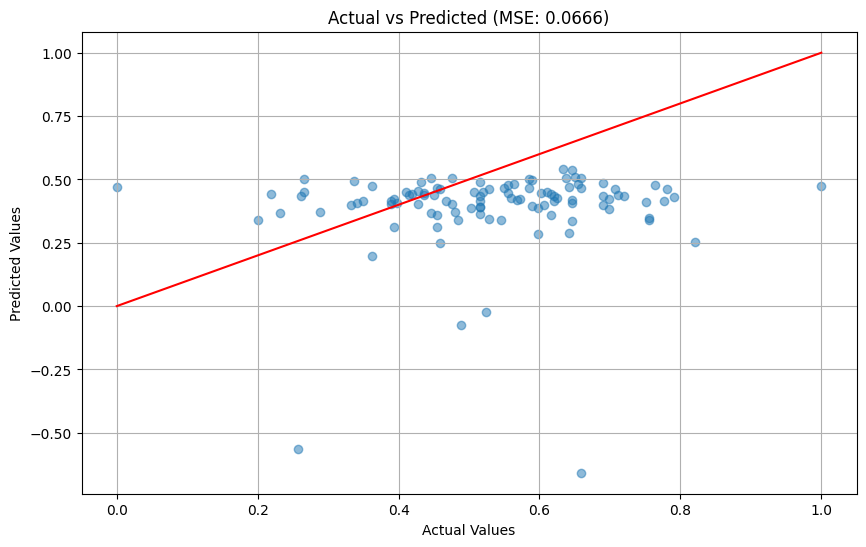

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# 예측 결과 CSV 파일 읽기
results_df = pd.read_csv('/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/densenet121_model_moisture_l_v1.csv')

# 실제값과 예측값 추출
actuals = results_df['Actual']
predictions = results_df['Predicted']

# MSE 계산
mse = mean_squared_error(actuals, predictions)
print(f'Mean Squared Error: {mse:.4f}')

# 산점도 시각화
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red')  # y=x 선
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted (MSE: {mse:.4f})')  # MSE를 제목에 추가
plt.grid(True)
plt.show()


# SkinNet

In [28]:
import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# 이미지 전처리 클래스
class ImagePreprocessor:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # 모델 입력 크기에 맞게 조정
            transforms.ToTensor(),  # 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
        ])

    def preprocess(self, image):
        return self.transform(image)

# SkinNet 모델 정의 클래스
class SkinNetModel(nn.Module):
    def __init__(self):
        super(SkinNetModel, self).__init__()
        # 기존의 모델을 사용하여 SkinNet을 정의 (예: ResNet을 기반으로 함)
        self.backbone = models.resnet50(pretrained=True)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_ftrs, 256)  # 특성 추출을 위한 추가 레이어
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)  # 최종 출력 레이어 (회귀 문제)

    def forward(self, x):
        x = self.backbone(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 모델 훈련 클래스
class SkinNetModelTrainer:
    def __init__(self):
        self.model = SkinNetModel()

    def train_and_evaluate(self, train_loader, val_loader):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        early_stopping = EarlyStopping(patience=4, min_delta=0.001)

        num_epochs = 50
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0

            for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            epoch_loss = running_loss / len(train_loader)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')

            val_loss = self.validate(val_loader, criterion)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')
            early_stopping(val_loss)

            if early_stopping.early_stop:
                print("Early stopping")
                break

        # 모델 저장
        torch.save(self.model.state_dict(), '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/skinnet_model_v1.pth')

    def validate(self, val_loader, criterion):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = self.model(images)
                loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float
                val_loss += loss.item()
        return val_loss / len(val_loader)

# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# 데이터셋 클래스
class SkinDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')  # 이미지를 RGB 모드로 열기
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float)  # Convert label to float tensor

# 메인 처리 클래스
class MainProcessor:
    def __init__(self, image_folder, csv_path):
        self.image_folder = image_folder
        self.csv_path = csv_path
        self.preprocessor = ImagePreprocessor()
        self.trainer = SkinNetModelTrainer()

    def extract_patches_and_labels(self):
        df = pd.read_csv(self.csv_path)
        image_files = []
        labels = []

        for image_file in os.listdir(self.image_folder):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(self.image_folder, image_file)
                image_id = image_file.split('_')[0]
                label_data = df[df['ID'] == int(image_id)]['moisture_l'].values
                if len(label_data) > 0:
                    label = label_data[0]
                    image_files.append(image_path)
                    labels.append(label)

        return image_files, labels

    def process_and_train(self):
        image_files, labels = self.extract_patches_and_labels()

        X_train, X_val, y_train, y_val = train_test_split(image_files, labels, test_size=0.2, random_state=42)

        train_dataset = SkinDataset(image_files=X_train, labels=y_train, transform=self.preprocessor.preprocess)
        val_dataset = SkinDataset(image_files=X_val, labels=y_val, transform=self.preprocessor.preprocess)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

        self.trainer.train_and_evaluate(train_loader, val_loader)

if __name__ == "__main__":
    train_image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_l_images_train'
    csv_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/train_val_dataset.csv'

    processor = MainProcessor(train_image_folder, csv_path)
    processor.process_and_train()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]
                                                           

Epoch [1/50], Train Loss: 0.1245


Epoch [1/50], Validation Loss: 0.1756


Epoch [2/50], Train Loss: 0.0217


Epoch [2/50], Validation Loss: 0.0241


Epoch [3/50], Train Loss: 0.0174


Epoch [3/50], Validation Loss: 0.0165


Epoch [4/50], Train Loss: 0.0179


Epoch [4/50], Validation Loss: 0.0240


Epoch [5/50], Train Loss: 0.0195


Epoch [5/50], Validation Loss: 0.0182


Epoch [6/50], Train Loss: 0.0186


Epoch [6/50], Validation Loss: 0.0149


Epoch [7/50], Train Loss: 0.0184


Epoch [7/50], Validation Loss: 0.0200


Epoch [8/50], Train Loss: 0.0220


Epoch [8/50], Validation Loss: 0.0191


Epoch [9/50], Train Loss: 0.0208


Epoch [9/50], Validation Loss: 0.0180


Epoch [10/50], Train Loss: 0.0168


Epoch [10/50], Validation Loss: 0.0169
Early stopping


In [31]:
import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn

# 이미지 전처리 클래스
class ImagePreprocessor:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # 모델 입력 크기에 맞게 조정
            transforms.ToTensor(),  # 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
        ])

    def preprocess(self, image):
        return self.transform(image)

# 데이터셋 클래스
class SkinDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')  # 이미지를 RGB 모드로 열기
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor([label], dtype=torch.float32)  # 2D 텐서로 변환

# SkinNet 모델 정의 클래스
class SkinNetModel(nn.Module):
    def __init__(self):
        super(SkinNetModel, self).__init__()
        # ResNet50 모델을 기반으로 SkinNet을 정의
        self.resnet = models.resnet50(weights='DEFAULT')  # 최신 권장 방식
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 256)  # 중간 레이어
        self.fc1 = nn.Linear(256, 128)  # 추가 전결합층
        self.fc2 = nn.Linear(128, 1)    # 최종 출력 레이어 (회귀 문제)

    def forward(self, x):
        x = self.resnet(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# SkinNet 모델 평가 클래스
class SkinNetModelEvaluator:
    def __init__(self, model_path):
        self.model = self.prepare_skinnet_model()
        self.model.load_state_dict(torch.load(model_path), strict=False)  # strict=False를 사용하여 일부 키 불일치 허용
        self.model.eval()

    def prepare_skinnet_model(self):
        return SkinNetModel()  # SkinNet 모델 인스턴스 생성

    def predict(self, test_loader):
        predictions = []
        actuals = []
        self.model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = self.model(images)
                predictions.extend(outputs.view(-1).cpu().numpy())
                actuals.extend(labels.view(-1).cpu().numpy())
        return actuals, predictions

# 테스트 및 예측 저장 클래스
class MainProcessor:
    def __init__(self, test_image_folder, csv_path, model_path):
        self.test_image_folder = test_image_folder
        self.csv_path = csv_path
        self.model_path = model_path
        self.preprocessor = ImagePreprocessor()
        self.evaluator = SkinNetModelEvaluator(model_path)

    def extract_data(self):
        df = pd.read_csv(self.csv_path)
        image_files = []
        labels = []

        for image_file in os.listdir(self.test_image_folder):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(self.test_image_folder, image_file)
                image_id = image_file.split('_')[0]
                label_data = df[df['ID'] == int(image_id)]['moisture_l'].values
                if len(label_data) > 0:
                    label = label_data[0]
                    image_files.append(image_path)
                    labels.append(label)

        return image_files, labels

    def process_and_predict(self):
        image_files, labels = self.extract_data()

        dataset = SkinDataset(image_files=image_files, labels=labels, transform=self.preprocessor.preprocess)
        data_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

        actuals, predictions = self.evaluator.predict(data_loader)

        return actuals, predictions

if __name__ == "__main__":
    test_image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_l_images_val'
    csv_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/train_val_dataset.csv'
    model_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/skinnet_model_v1.pth'

    processor = MainProcessor(test_image_folder, csv_path, model_path)
    actuals, predictions = processor.process_and_predict()

    # 예측값과 실제값을 CSV로 저장
    results_df = pd.DataFrame({'Actual': actuals, 'Predicted': predictions})
    results_df.to_csv('/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/skinnet_model_moisture_l_v1.csv', index=False)



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


Mean Squared Error: 0.3409
R² Score: -13.0249


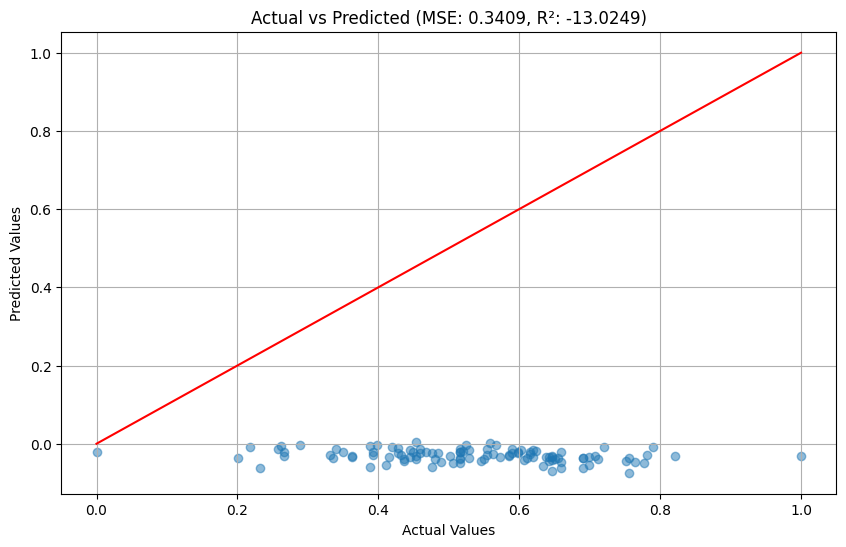

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# 예측 결과 CSV 파일 읽기
results_df = pd.read_csv('/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/model/skinnet_model_moisture_l_v1.csv')

# 실제값과 예측값 추출
actuals = results_df['Actual']
predictions = results_df['Predicted']

# MSE 및 결정계수 계산
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f'Mean Squared Error: {mse:.4f}')
print(f'R² Score: {r2:.4f}')

# 산점도 시각화
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red')  # y=x 선
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted (MSE: {mse:.4f}, R²: {r2:.4f})')  # MSE와 R²를 제목에 추가
plt.grid(True)
plt.show()
